<a href="https://colab.research.google.com/github/gptix/DS-Unit-2-Kaggle-Challenge/blob/master/module1/Jud_Taylor_assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


## Split data into train, validate, and test sets.


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

# Further split the 'train's set into 'train' and 'val'.
# The new 'train' set will be 80% of the original set.
# Specify the 'random_state' parameter explicitly, so that behavior will be 
# replicable.   
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

print(f"Train shape: {train.shape}, Val shape: {val.shape}, Test shape: {test.shape}.")

Train shape: (47520, 41), Val shape: (11880, 41), Test shape: (14358, 40).


## Establish baselines.

In [8]:
# These are baseline percentages.
status_percentages = train['status_group'].value_counts(normalize=True)
status_percentages
functional_percentage, non_functional_percentage, functional_needs_repair_percentage  = status_percentages

print(f'{functional_percentage, non_functional_percentage, functional_needs_repair_percentage}')

(0.5430765993265994, 0.38423821548821546, 0.07268518518518519)


In [0]:
# Pandas Profiling can be very slow with medium & large datasets.
# These parameters will make it faster.
# https://github.com/pandas-profiling/pandas-profiling/issues/222

# import pandas_profiling

# profile_report = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )

# profile_report

In [0]:
import numpy as np

def wrangle(X):
    """A standard set of steps to wrangle data in sets."""
    
    # Prevent SettingWithCopyWarning
    # Make a copy of the dataframe received.
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    # Use the replace method on the column '
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # We know that none of the pumps are located at logitude or latitude zero.
    # So, we should replace these values, temporarily, with zeros, so that
    # a later step can impute more appropriate values.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # The columns 'quantity' & 'quantity_group' are duplicates, so we drop one.
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe.
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

## Select features. 

In [24]:
# The value to be predicted is 'status_group'.
target = 'status_group'

# Make a list of all features except the target.  This might be changed by 
# dropping further columns. We also drop the 'id' column.
train_features = train.drop(columns=[target, 'id'])

# Get numeric features (as a Pandas series).
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get non-numeric features with relatively low cardinality.
## Get the cardinality of the NON-numeric features (as a Pandas series).
cardinality = train_features.select_dtypes(exclude='number').nunique()

## Get a list of all categorical features with cardinality below (or) 50.
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Concatenate the two series to list all features.
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']



## Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [0]:
from sklearn.pipeline import make_pipeline

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=1984)
)

## Create X (feature matrix) and y (target vector) for train, val, and test (but we do not have the target column for test.).


In [0]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'wat...
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=N

## Validation accuracy score.

In [35]:
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Validation accuracy: 0.7595117845117845


## Plot your feature importances.

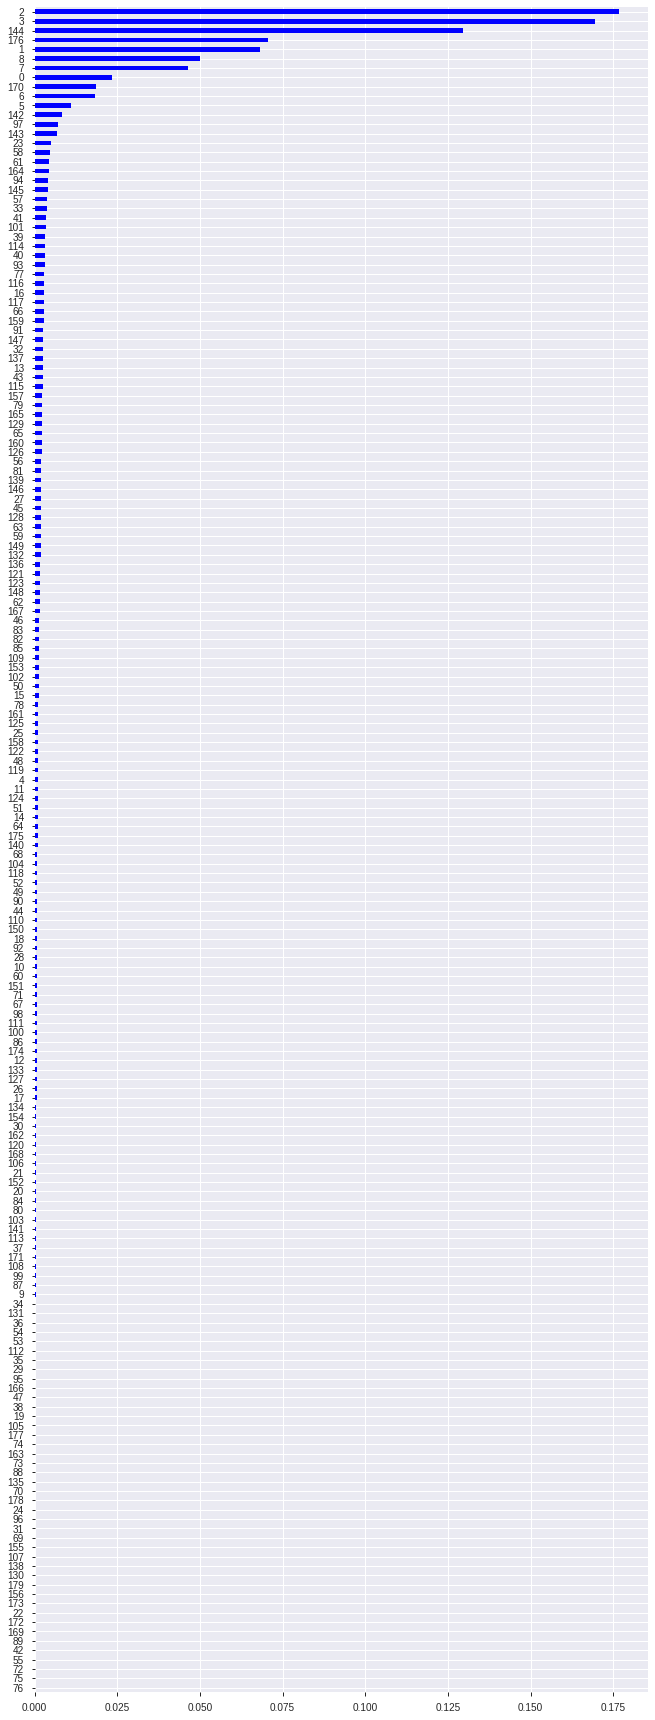

In [44]:
model = pipeline.named_steps['decisiontreeclassifier']

encoder = pipeline.named_steps['onehotencoder']
encoded_cols = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(11,31))

importances.sort_values().plot.barh(color='blue')

## Create CSV file for upload to Kaggle.

In [0]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, # with the same number of 
# rows, in the same order, as test_features.csv, and the same number of columns,
#  in the same order, as X_train

y_pred = pipeline.predict(X_test)

# y_pred.shape

submission = sample_submission.copy()
submission['status_group'] = y_pred
# submission.head()


submission_filename = 'Jud_Taylor_DS10_Kaggle.csv'

submission.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)